In [1]:
from seaborn.utils import os, plt, np, pd
import seaborn as sns
from tensorflow.keras import backend as K, models, layers, optimizers, metrics as k_mtr, callbacks

In [2]:
from sklearn import svm, multioutput, preprocessing as s_prep, model_selection as s_ms, metrics as s_mtr
from sklearn import decomposition as s_decomp, feature_selection as s_fs

In [3]:
from project_methods import RoadAccidents as proj

In [4]:
help(pd.set_option)

Help on CallableDynamicDoc in module pandas._config.config:

<pandas._config.config.CallableDynamicDoc object>
    set_option(pat, value)
    
    Sets the value of the specified option.
    
    Available options:
    
    - compute.[use_bottleneck, use_numba, use_numexpr]
    - display.[chop_threshold, colheader_justify, column_space, date_dayfirst,
      date_yearfirst, encoding, expand_frame_repr, float_format]
    - display.html.[border, table_schema, use_mathjax]
    - display.[large_repr]
    - display.latex.[escape, longtable, multicolumn, multicolumn_format, multirow,
      repr]
    - display.[max_categories, max_columns, max_colwidth, max_info_columns,
      max_info_rows, max_rows, max_seq_items, memory_usage, min_rows, multi_sparse,
      notebook_repr_html, pprint_nest_depth, precision, show_dimensions]
    - display.unicode.[ambiguous_as_wide, east_asian_width]
    - display.[width]
    - io.excel.ods.[reader, writer]
    - io.excel.xls.[reader, writer]
    - io.excel.xl

In [5]:
pd.set_option('display.precision', 3,
             'display.max_columns', None)

In [6]:
data_folder = 'RoadAccidentsOutput//accidents_ext.csv'
accidents = pd.read_csv(data_folder, low_memory=False)
accidents

,accident_index,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,number_of_casualties,day_of_week,local_authority_district,local_authority_highway,1st_road_class,1st_road_number,road_type,speed_limit,junction_detail,junction_control,2nd_road_class,2nd_road_number,pedestrian_crossing_human_control,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,lsoa_of_accident_location,vehicle_reference_x,vehicle_type,towing_and_articulation,vehicle_manoeuvre,vehicle_location_restricted_lane,junction_location,skidding_and_overturning,hit_object_in_carriageway,vehicle_leaving_carriageway,hit_object_off_carriageway,1st_point_of_impact,was_vehicle_left_hand_drive,journey_purpose_of_driver,sex_of_driver,age_of_driver,age_band_of_driver,engine_capacity_cc,propulsion_code,age_of_vehicle,driver_imd_decile,driver_home_area_type,vehicle_imd_decile,vehicle_reference_y,casualty_reference,casualty_class,sex_of_casualty,age_of_casualty,age_band_of_casualty,casualty_severity,pedestrian_location,pedestrian_movement,car_passenger,bus_or_coach_passenger,pedestrian_road_maintenance_worker,casualty_type,casualty_home_area_type,casualty_imd_decile,hour,minute,part_of_day_num,month,day,quarter,month_name,week_num,day_num,day_name,is_weekend,season,is_dst,is_offseason,is_sunrise,is_sunset
0,2019010128300,528218.0,180407.0,-0.154,51.508,1.0,3.0,2.0,3.0,1,1.0,E09000033,3.0,4202.0,1.0,30.0,1.0,2.0,3.0,4202.0,0.0,5.0,1.0,1.0,1.0,0.0,0.0,1.0,3.0,E01004762,1.0,9.0,0.0,18.0,0.0,1.0,0.0,0.0,1.0,0.0,4.0,1.0,6.0,1.0,58.0,9.0,124.0,0.0,7.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,58.0,9.0,3.0,0.0,0.0,0.0,0.0,0.0,9.0,1.0,2.0,17,50,3.0,2,18,1,February,8,49,Monday,0,winter,0,0,0,0
1,2019010128300,528218.0,180407.0,-0.154,51.508,1.0,3.0,2.0,3.0,1,1.0,E09000033,3.0,4202.0,1.0,30.0,1.0,2.0,3.0,4202.0,0.0,5.0,1.0,1.0,1.0,0.0,0.0,1.0,3.0,E01004762,2.0,9.0,0.0,18.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,6.0,3.0,19.0,4.0,124.0,0.0,7.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,58.0,9.0,3.0,0.0,0.0,0.0,0.0,0.0,9.0,1.0,2.0,17,50,3.0,2,18,1,February,8,49,Monday,0,winter,0,0,0,0
2,2019010155191,530222.0,182543.0,-0.124,51.527,1.0,3.0,2.0,1.0,2,2.0,E09000007,4.0,504.0,6.0,30.0,3.0,4.0,6.0,0.0,0.0,0.0,4.0,1.0,1.0,0.0,0.0,1.0,1.0,E01000943,1.0,9.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,6.0,1.0,45.0,7.0,124.0,0.0,7.0,4.0,1.0,4.0,2.0,1.0,2.0,2.0,21.0,5.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1,50,4.0,1,1,1,January,1,1,Tuesday,0,winter,0,0,0,0
3,2019010155191,530222.0,182543.0,-0.124,51.527,1.0,3.0,2.0,1.0,2,2.0,E09000007,4.0,504.0,6.0,30.0,3.0,4.0,6.0,0.0,0.0,0.0,4.0,1.0,1.0,0.0,0.0,1.0,1.0,E01000943,2.0,1.0,0.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,33.0,6.0,124.0,0.0,7.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,21.0,5.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1,50,4.0,1,1,1,January,1,1,Tuesday,0,winter,0,0,0,0
4,2019010155192,525531.0,184605.0,-0.191,51.546,1.0,2.0,1.0,1.0,2,2.0,E09000007,4.0,510.0,6.0,20.0,3.0,4.0,4.0,510.0,0.0,0.0,4.0,1.0,1.0,0.0,0.0,1.0,1.0,E01000973,1.0,9.0,0.0,18.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,32.0,6.0,124.0,0.0,7.0,3.0,1.0,3.0,1.0,1.0,3.0,1.0,68.0,10.0,2.0,5.0,4.0,0.0,0.0,0.0,0.0,1.0,4.0,1,20,4.0,1,1,1,January,1,1,Tuesday,0,winter,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275515,2019984107019,337522.0,591682.0,-2.983,55.215,98.0,3.0,4.0,1.0,4,917.0,S12000006,3.0,7.0,6.0,60.0,0.0,4.0,6.0,0.0,0.0,0.0,1.0,1.0,2.0,0.0,0.0,2.0,1.0,E01002444,4.0,19.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,1.0,1.0,20.0,4.0,2198.0,2.0,4.0,5.0,3.0,5.0,1.0,1.0,1.0,1.0,22.0,5.0,3.0,0.0,0.0,0.0,0.0,0.0,19.0,1.0,1

In [7]:
# encode categorical variable
accidents.select_dtypes(exclude='number')

,accident_index,local_authority_highway,lsoa_of_accident_location,month_name,day_name,season
0,2019010128300,E09000033,E01004762,February,Monday,winter
1,2019010128300,E09000033,E01004762,February,Monday,winter
2,2019010155191,E09000007,E01000943,January,Tuesday,winter
3,2019010155191,E09000007,E01000943,January,Tuesday,winter
4,2019010155192,E09000007,E01000973,January,Tuesday,winter
...,...,...,...,...,...,...
275515,2019984107019,S12000006,E01002444,May,Thursday,spring
275516,2019984107219,S12000006,E01002444,June,Friday,summer
275517,2019984107219,S12000006,E01002444,June,Friday,summer
275518,2019984107419,S12000006,E01002444,June,Saturday,summer


In [8]:
season = {'winter':1, 'spring':2, 'summer':3, 'autumn':4}
accidents['season'] = accidents['season'].map(season)

In [9]:
X = accidents.select_dtypes(include='number').drop(['longitude', 'latitude', 'hour', 'minute',
                                                    'is_sunrise', 'is_sunset'], axis=1)
display(X)
time_y = accidents.apply(lambda x: x['hour'] + x['minute']/60, axis=1)
long_x = accidents['longitude']
lat_y = accidents['latitude']
severity_y = accidents['accident_severity']
display(time_y, long_x, lat_y, severity_y)

,location_easting_osgr,location_northing_osgr,police_force,accident_severity,number_of_vehicles,number_of_casualties,day_of_week,local_authority_district,1st_road_class,1st_road_number,road_type,speed_limit,junction_detail,junction_control,2nd_road_class,2nd_road_number,pedestrian_crossing_human_control,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,vehicle_reference_x,vehicle_type,towing_and_articulation,vehicle_manoeuvre,vehicle_location_restricted_lane,junction_location,skidding_and_overturning,hit_object_in_carriageway,vehicle_leaving_carriageway,hit_object_off_carriageway,1st_point_of_impact,was_vehicle_left_hand_drive,journey_purpose_of_driver,sex_of_driver,age_of_driver,age_band_of_driver,engine_capacity_cc,propulsion_code,age_of_vehicle,driver_imd_decile,driver_home_area_type,vehicle_imd_decile,vehicle_reference_y,casualty_reference,casualty_class,sex_of_casualty,age_of_casualty,age_band_of_casualty,casualty_severity,pedestrian_location,pedestrian_movement,car_passenger,bus_or_coach_passenger,pedestrian_road_maintenance_worker,casualty_type,casualty_home_area_type,casualty_imd_decile,part_of_day_num,month,day,quarter,week_num,day_num,is_weekend,season,is_dst,is_offseason
0,528218.0,180407.0,1.0,3.0,2.0,3.0,1,1.0,3.0,4202.0,1.0,30.0,1.0,2.0,3.0,4202.0,0.0,5.0,1.0,1.0,1.0,0.0,0.0,1.0,3.0,1.0,9.0,0.0,18.0,0.0,1.0,0.0,0.0,1.0,0.0,4.0,1.0,6.0,1.0,58.0,9.0,124.0,0.0,7.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,58.0,9.0,3.0,0.0,0.0,0.0,0.0,0.0,9.0,1.0,2.0,3.0,2,18,1,8,49,0,1,0,0
1,528218.0,180407.0,1.0,3.0,2.0,3.0,1,1.0,3.0,4202.0,1.0,30.0,1.0,2.0,3.0,4202.0,0.0,5.0,1.0,1.0,1.0,0.0,0.0,1.0,3.0,2.0,9.0,0.0,18.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,6.0,3.0,19.0,4.0,124.0,0.0,7.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,58.0,9.0,3.0,0.0,0.0,0.0,0.0,0.0,9.0,1.0,2.0,3.0,2,18,1,8,49,0,1,0,0
2,530222.0,182543.0,1.0,3.0,2.0,1.0,2,2.0,4.0,504.0,6.0,30.0,3.0,4.0,6.0,0.0,0.0,0.0,4.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,9.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,6.0,1.0,45.0,7.0,124.0,0.0,7.0,4.0,1.0,4.0,2.0,1.0,2.0,2.0,21.0,5.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,4.0,1,1,1,1,1,0,1,0,0
3,530222.0,182543.0,1.0,3.0,2.0,1.0,2,2.0,4.0,504.0,6.0,30.0,3.0,4.0,6.0,0.0,0.0,0.0,4.0,1.0,1.0,0.0,0.0,1.0,1.0,2.0,1.0,0.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,33.0,6.0,124.0,0.0,7.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,21.0,5.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,4.0,1,1,1,1,1,0,1,0,0
4,525531.0,184605.0,1.0,2.0,1.0,1.0,2,2.0,4.0,510.0,6.0,20.0,3.0,4.0,4.0,510.0,0.0,0.0,4.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,9.0,0.0,18.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,32.0,6.0,124.0,0.0,7.0,3.0,1.0,3.0,1.0,1.0,3.0,1.0,68.0,10.0,2.0,5.0,4.0,0.0,0.0,0.0,0.0,1.0,4.0,4.0,1,1,1,1,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275515,337522.0,591682.0,98.0,3.0,4.0,1.0,4,917.0,3.0,7.0,6.0,60.0,0.0,4.0,6.0,0.0,0.0,0.0,1.0,1.0,2.0,0.0,0.0,2.0,1.0,4.0,19.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,1.0,1.0,20.0,4.0,2198.0,2.0,4.0,5.0,3.0,5.0,1.0,1.0,1.0,1.0,22.0,5.0,3.0,0.0,0.0,0.0,0.0,0.0,19.0,1.0,1.0,1.0,5,30,2,22,150,0,2,1,1
275516,318544.0,567087.0,98.0,3.0,2.0,1.0,5,917.0,4.0,723.0,6.0,60.0,3.0,4.0,4.0,721.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,2.0,1.0,9.0,0.0,18.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,6.0,1.0,33.0,6.0,1997.0,2.0,12.0,3.0,2.0,3.0,2.0,1.0,1.0,1.0,61.0,9.0,3.0,0.0,0.0,0.0,0.0,0.0,9.0,3.0,7.0,2.0,6,21,2,25,172,0,3,1,1
275517,318544.0,567087.0,98.0,3.0,2.0,1.0,5,917.0,4.0,723.0,6.0,60.0,3.0,4.0,4.0,721.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,2.0,2.0,9.0,0.0,18.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,1.0,61.0,9.0,2967.0,2.0,5.0,7.0,3.0,7.0,2.0,1.0,1.0,1.0,61.0,9.0,3.0,0.0,0.0,0.0,0.0,0.0,9.0,3.0,7.0,2.0,6,21,2,

0         17.833
1         17.833
2          1.833
3          1.833
4          1.333
           ...  
275515     8.767
275516    15.500
275517    15.500
275518    14.167
275519    12.750
Length: 275520, dtype: float64

0        -0.154
1        -0.154
2        -0.124
3        -0.124
4        -0.191
          ...  
275515   -2.983
275516   -3.275
275517   -3.275
275518   -2.997
275519   -3.715
Name: longitude, Length: 275520, dtype: float64

0         51.508
1         51.508
2         51.527
3         51.527
4         51.546
           ...  
275515    55.215
275516    54.992
275517    54.992
275518    55.148
275519    55.357
Name: latitude, Length: 275520, dtype: float64

0         3.0
1         3.0
2         3.0
3         3.0
4         2.0
         ... 
275515    3.0
275516    3.0
275517    3.0
275518    3.0
275519    2.0
Name: accident_severity, Length: 275520, dtype: float64

In [10]:
print(accidents.columns)

Index(['accident_index', 'location_easting_osgr', 'location_northing_osgr',
       'longitude', 'latitude', 'police_force', 'accident_severity',
       'number_of_vehicles', 'number_of_casualties', 'day_of_week',
       'local_authority_district', 'local_authority_highway', '1st_road_class',
       '1st_road_number', 'road_type', 'speed_limit', 'junction_detail',
       'junction_control', '2nd_road_class', '2nd_road_number',
       'pedestrian_crossing_human_control',
       'pedestrian_crossing_physical_facilities', 'light_conditions',
       'weather_conditions', 'road_surface_conditions',
       'special_conditions_at_site', 'carriageway_hazards',
       'urban_or_rural_area', 'did_police_officer_attend_scene_of_accident',
       'lsoa_of_accident_location', 'vehicle_reference_x', 'vehicle_type',
       'towing_and_articulation', 'vehicle_manoeuvre',
       'vehicle_location_restricted_lane', 'junction_location',
       'skidding_and_overturning', 'hit_object_in_carriageway',
     

In [11]:
candidate_variables = ['location_easting_osgr', 'location_northing_osgr', 'police_force',  'day_of_week',
 'local_authority_district', 'local_authority_highway', '1st_road_class',
 '1st_road_number', 'road_type', 'speed_limit', 'junction_detail',
'junction_control', '2nd_road_class', '2nd_road_number',
'pedestrian_crossing_human_control', 'pedestrian_crossing_physical_facilities', 'light_conditions',
 'weather_conditions', 'road_surface_conditions',
'special_conditions_at_site', 'carriageway_hazards', 'urban_or_rural_area',
'lsoa_of_accident_location', 'vehicle_manoeuvre', 'vehicle_location_restricted_lane', 'junction_location',
'vehicle_leaving_carriageway', 'was_vehicle_left_hand_drive',
'journey_purpose_of_driver', 'sex_of_driver', 'age_of_driver',
'age_band_of_driver', 'engine_capacity_cc', 'propulsion_code',
 'age_of_vehicle', 'driver_imd_decile', 'driver_home_area_type',
'vehicle_imd_decile', 'casualty_class', 'sex_of_casualty', 'age_of_casualty',
'age_band_of_casualty', 'pedestrian_location',
'pedestrian_movement', 'car_passenger', 'bus_or_coach_passenger',
 'pedestrian_road_maintenance_worker', 'casualty_type',
'casualty_home_area_type', 'casualty_imd_decile','month', 'day', 'quarter', 'week_num',
'day_num',  'is_weekend', 'season', 'is_dst', 'is_offseason']

In [12]:
# drop auto_correlated variables
# dropped_cols = ['location_easting_osgr', 'location_northing_osgr', 'police_force', 'age_of_driver',  '1st_point_of_impact',
#                 'casualty_severity', 'accident_severity', 'age_of_casualty', 'driver_imd_decile','quarter', 
#                 'week_num', 'day_num','part_of_day_num', 'vehicle_reference_x',  'vehicle_reference_y', 'casualty_reference']

# resettting highway to model-friendly integer codes
X = accidents[candidate_variables]
hw = tuple(X['local_authority_highway'].unique())
higway_codes = {h:n for n, h in zip(range(1, len(hw) + 1), hw)}
X.loc[:, 'local_authority_highway'] = X['local_authority_highway'].map(higway_codes)

lsoa = tuple(X['lsoa_of_accident_location'].unique())
lsoa_codes = {h:n for n, h in zip(range(1, len(lsoa) + 1), lsoa)}
X.loc[:, 'lsoa_of_accident_location'] = X['lsoa_of_accident_location'].map(lsoa_codes)
X

C:\Users\welcome\venv\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,location_easting_osgr,location_northing_osgr,police_force,day_of_week,local_authority_district,local_authority_highway,1st_road_class,1st_road_number,road_type,speed_limit,junction_detail,junction_control,2nd_road_class,2nd_road_number,pedestrian_crossing_human_control,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,lsoa_of_accident_location,vehicle_manoeuvre,vehicle_location_restricted_lane,junction_location,vehicle_leaving_carriageway,was_vehicle_left_hand_drive,journey_purpose_of_driver,sex_of_driver,age_of_driver,age_band_of_driver,engine_capacity_cc,propulsion_code,age_of_vehicle,driver_imd_decile,driver_home_area_type,vehicle_imd_decile,casualty_class,sex_of_casualty,age_of_casualty,age_band_of_casualty,pedestrian_location,pedestrian_movement,car_passenger,bus_or_coach_passenger,pedestrian_road_maintenance_worker,casualty_type,casualty_home_area_type,casualty_imd_decile,month,day,quarter,week_num,day_num,is_weekend,season,is_dst,is_offseason
0,528218.0,180407.0,1.0,1,1.0,1,3.0,4202.0,1.0,30.0,1.0,2.0,3.0,4202.0,0.0,5.0,1.0,1.0,1.0,0.0,0.0,1.0,1,18.0,0.0,1.0,1.0,1.0,6.0,1.0,58.0,9.0,124.0,0.0,7.0,2.0,1.0,2.0,1.0,1.0,58.0,9.0,0.0,0.0,0.0,0.0,0.0,9.0,1.0,2.0,2,18,1,8,49,0,1,0,0
1,528218.0,180407.0,1.0,1,1.0,1,3.0,4202.0,1.0,30.0,1.0,2.0,3.0,4202.0,0.0,5.0,1.0,1.0,1.0,0.0,0.0,1.0,1,18.0,0.0,1.0,1.0,1.0,6.0,3.0,19.0,4.0,124.0,0.0,7.0,2.0,1.0,2.0,1.0,1.0,58.0,9.0,0.0,0.0,0.0,0.0,0.0,9.0,1.0,2.0,2,18,1,8,49,0,1,0,0
2,530222.0,182543.0,1.0,2,2.0,2,4.0,504.0,6.0,30.0,3.0,4.0,6.0,0.0,0.0,0.0,4.0,1.0,1.0,0.0,0.0,1.0,2,3.0,0.0,1.0,0.0,1.0,6.0,1.0,45.0,7.0,124.0,0.0,7.0,4.0,1.0,4.0,2.0,2.0,21.0,5.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1,1,1,1,1,0,1,0,0
3,530222.0,182543.0,1.0,2,2.0,2,4.0,504.0,6.0,30.0,3.0,4.0,6.0,0.0,0.0,0.0,4.0,1.0,1.0,0.0,0.0,1.0,2,4.0,0.0,1.0,0.0,1.0,1.0,1.0,33.0,6.0,124.0,0.0,7.0,2.0,1.0,2.0,2.0,2.0,21.0,5.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1,1,1,1,1,0,1,0,0
4,525531.0,184605.0,1.0,2,2.0,2,4.0,510.0,6.0,20.0,3.0,4.0,4.0,510.0,0.0,0.0,4.0,1.0,1.0,0.0,0.0,1.0,3,18.0,0.0,2.0,0.0,1.0,1.0,1.0,32.0,6.0,124.0,0.0,7.0,3.0,1.0,3.0,3.0,1.0,68.0,10.0,5.0,4.0,0.0,0.0,0.0,0.0,1.0,4.0,1,1,1,1,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275515,337522.0,591682.0,98.0,4,917.0,207,3.0,7.0,6.0,60.0,0.0,4.0,6.0,0.0,0.0,0.0,1.0,1.0,2.0,0.0,0.0,2.0,721,18.0,0.0,0.0,0.0,1.0,1.0,1.0,20.0,4.0,2198.0,2.0,4.0,5.0,3.0,5.0,1.0,1.0,22.0,5.0,0.0,0.0,0.0,0.0,0.0,19.0,1.0,1.0,5,30,2,22,150,0,2,1,1
275516,318544.0,567087.0,98.0,5,917.0,207,4.0,723.0,6.0,60.0,3.0,4.0,4.0,721.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,721,18.0,0.0,1.0,0.0,1.0,6.0,1.0,33.0,6.0,1997.0,2.0,12.0,3.0,2.0,3.0,1.0,1.0,61.0,9.0,0.0,0.0,0.0,0.0,0.0,9.0,3.0,7.0,6,21,2,25,172,0,3,1,1
275517,318544.0,567087.0,98.0,5,917.0,207,4.0,723.0,6.0,60.0,3.0,4.0,4.0,721.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,721,18.0,0.0,1.0,0.0,1.0,6.0,1.0,61.0,9.0,2967.0,2.0,5.0,7.0,3.0,7.0,1.0,1.0,61.0,9.0,0.0,0.0,0.0,0.0,0.0,9.0,3.0,7.0,6,21,2,25,172,0,3,1,1
275518,336525.0,584226.0,98.0,6,917.0,207,6.0,710.0,6.0,30.0,3.0,4.0,6.0,723.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,721,7.0,0.0,6.0,3.0,1.0,5.0,1.0,78.0,11.0,1597.0,2.0,6.0,8.0,3.0,8.0,3.0,1.0,54.0,8.0,5.0,3.0,0.0,0.0,0.0,0.0,3.0,8.0,6,29,2,26,180,1,3,1,1


#### TRAIN TIME OF ACCIDENT (FULL HOUR) REGRESSOR (NN)

#### FEATURE SELECTION

In [13]:
selector = s_fs.SelectKBest(k='all')
selector.fit(X, time_y)

SelectKBest(k='all')

In [14]:
top15_features = pd.Series(selector.scores_, index=selector.feature_names_in_).sort_values(ascending=False).iloc[:15].index
top15_features

Index(['light_conditions', 'journey_purpose_of_driver', 'age_of_casualty',
       'age_of_driver', 'road_surface_conditions', 'age_band_of_driver',
       'age_band_of_casualty', 'lsoa_of_accident_location', 'speed_limit',
       'is_weekend', 'urban_or_rural_area', 'day_of_week',
       'location_northing_osgr', '1st_road_class', 'bus_or_coach_passenger'],
      dtype='object')

In [15]:
top15 = X.corrwith(time_y).abs().sort_values(ascending=False).iloc[:15].index
top15

Index(['light_conditions', 'journey_purpose_of_driver', 'age_band_of_casualty',
       'age_of_casualty', 'age_band_of_driver', 'age_of_driver',
       'engine_capacity_cc', 'urban_or_rural_area', 'car_passenger',
       'speed_limit', '1st_road_class', 'junction_detail',
       'casualty_imd_decile', 'casualty_class', 'road_surface_conditions'],
      dtype='object')

In [16]:
(x_train, x_val, x_test, y_train, y_val, y_test) = proj.dataset_split(X[top15_features].values, time_y.values,
                                                                    perc_test=0.30, perc_val=0.5)

NameError: name 'ds' is not defined

In [64]:
display(x_train.shape, x_test.shape, x_val.shape)

(192864, 15)

(41328, 15)

(41328, 15)

In [65]:
time_pred_scaler = s_prep.MinMaxScaler()

In [69]:
sc_xtrain = pd.DataFrame(time_pred_scaler.fit_transform(x_train),
                         columns=top15_features)
sc_xtest = pd.DataFrame(time_pred_scaler.transform(x_test),
                        columns=top15_features)
sc_xval = pd.DataFrame(time_pred_scaler.transform(x_val),
                        columns=top15_features)

In [70]:
sc_xtrain.shape

(192864, 15)

In [71]:
# saving scaler object


In [72]:
# reduce dimensions using pca to principal components
# with 95% of explained variance
pca = s_decomp.PCA(0.95)
pca.fit(sc_xtrain)
train_pca = pca.transform(sc_xtrain)
test_pca = pca.transform(sc_xtest)
val_pca = pca.transform(sc_xval)

In [73]:
display(train_pca.shape, test_pca.shape, val_pca.shape)
# display(train_pca, val_pca)

(192864, 10)

(41328, 10)

(41328, 10)

In [78]:
at_nnet = proj.build_nn(train_pca.shape[1], output_units=1, output_actvn=None, 
                        loss=lambda x, y: k_mtr.mean_squared_error(x, y),
                        metric=lambda x, y: k_mtr.mean_squared_error(x, y),
                        lr=3.5e-4)

Input features: 10
Learining Rate: 0.00035


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               1100      
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 20)                1020      
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total param

In [79]:
proj.show_layer_shapes(at_nnet)

Layer 0: 
Input_shape: (None, 10)
Output shape: (None, 100)


Layer 1: 
Input_shape: (None, 100)
Output shape: (None, 50)


Layer 2: 
Input_shape: (None, 50)
Output shape: (None, 50)


Layer 3: 
Input_shape: (None, 50)
Output shape: (None, 20)


Layer 4: 
Input_shape: (None, 20)
Output shape: (None, 20)


Layer 5: 
Input_shape: (None, 20)
Output shape: (None, 1)




In [80]:
at_nnet.fit(train_pca, y_train, epochs=150, validation_data=[val_pca, y_val], 
      callbacks=callbacks.EarlyStopping(patience=10, mode='min', monitor='val_loss'),
           batch_size=64)

Epoch 1/150
3014/3014 [==============================] - 10s 3ms/step - loss: 49.5672 - val_loss: 25.4210
Epoch 2/150
3014/3014 [==============================] - 9s 3ms/step - loss: 39.9759 - val_loss: 25.3383
Epoch 3/150
3014/3014 [==============================] - 9s 3ms/step - loss: 37.2956 - val_loss: 25.5501
Epoch 4/150
3014/3014 [==============================] - 8s 3ms/step - loss: 34.8980 - val_loss: 24.9710
Epoch 5/150
3014/3014 [==============================] - 11s 4ms/step - loss: 32.7245 - val_loss: 25.0626
Epoch 6/150
3014/3014 [==============================] - 12s 4ms/step - loss: 31.3550 - val_loss: 24.3161
Epoch 7/150
1387/3014 [============>.................] - ETA: 4s - loss: 30.1698

KeyboardInterrupt: 

In [ ]:
report = pd.DataFrame(at_nnet.history.history)
report

In [ ]:
sns.set_style('darkgrid')
ax = viz.plot_line(x=report.index, y=report['loss'], color='red', legend_labe='Training', show_legend=True)
viz.plot_line(x=report.index, y=report['val_loss'], color='blue', legend_labe='Validation', show_legend=True, axis=ax)

In [30]:
pred = at_nnet.predict(val_pca)

In [31]:
rmse = s_mtr.mean_squared_error(y_val, pred, squared=True)
rmse

21.765392307415716

In [32]:
s_mtr.r2_score(y_val, pred)

0.17194339230854816

In [33]:
fname = 'accident_time_classifier.h5'
models.save_model(at_nnet, fname)

In [34]:
model = models.load_model(fname, compile=False)

#### TRAIN SEVERITY CLASSIFIER (NN)

In [81]:
# resettting highway to model-friendly integer codes
use_df = accidents.loc[severity_y != 1].reset_index(drop=True)
X = use_df[candidate_variables]
hw = tuple(X['local_authority_highway'].unique())
higway_codes = {h:n for n, h in zip(range(1, len(hw) + 1), hw)}
X.loc[:, 'local_authority_highway'] = X['local_authority_highway'].map(higway_codes)

lsoa = tuple(X['lsoa_of_accident_location'].unique())
lsoa_codes = {h:n for n, h in zip(range(1, len(lsoa) + 1), lsoa)}
X.loc[:, 'lsoa_of_accident_location'] = X['lsoa_of_accident_location'].map(lsoa_codes)
X

C:\Users\welcome\venv\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,location_easting_osgr,location_northing_osgr,police_force,day_of_week,local_authority_district,local_authority_highway,1st_road_class,1st_road_number,road_type,speed_limit,junction_detail,junction_control,2nd_road_class,2nd_road_number,pedestrian_crossing_human_control,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,lsoa_of_accident_location,vehicle_manoeuvre,vehicle_location_restricted_lane,junction_location,vehicle_leaving_carriageway,was_vehicle_left_hand_drive,journey_purpose_of_driver,sex_of_driver,age_of_driver,age_band_of_driver,engine_capacity_cc,propulsion_code,age_of_vehicle,driver_imd_decile,driver_home_area_type,vehicle_imd_decile,casualty_class,sex_of_casualty,age_of_casualty,age_band_of_casualty,pedestrian_location,pedestrian_movement,car_passenger,bus_or_coach_passenger,pedestrian_road_maintenance_worker,casualty_type,casualty_home_area_type,casualty_imd_decile,month,day,quarter,week_num,day_num,is_weekend,season,is_dst,is_offseason
0,528218.0,180407.0,1.0,1,1.0,1,3.0,4202.0,1.0,30.0,1.0,2.0,3.0,4202.0,0.0,5.0,1.0,1.0,1.0,0.0,0.0,1.0,1,18.0,0.0,1.0,1.0,1.0,6.0,1.0,58.0,9.0,124.0,0.0,7.0,2.0,1.0,2.0,1.0,1.0,58.0,9.0,0.0,0.0,0.0,0.0,0.0,9.0,1.0,2.0,2,18,1,8,49,0,1,0,0
1,528218.0,180407.0,1.0,1,1.0,1,3.0,4202.0,1.0,30.0,1.0,2.0,3.0,4202.0,0.0,5.0,1.0,1.0,1.0,0.0,0.0,1.0,1,18.0,0.0,1.0,1.0,1.0,6.0,3.0,19.0,4.0,124.0,0.0,7.0,2.0,1.0,2.0,1.0,1.0,58.0,9.0,0.0,0.0,0.0,0.0,0.0,9.0,1.0,2.0,2,18,1,8,49,0,1,0,0
2,530222.0,182543.0,1.0,2,2.0,2,4.0,504.0,6.0,30.0,3.0,4.0,6.0,0.0,0.0,0.0,4.0,1.0,1.0,0.0,0.0,1.0,2,3.0,0.0,1.0,0.0,1.0,6.0,1.0,45.0,7.0,124.0,0.0,7.0,4.0,1.0,4.0,2.0,2.0,21.0,5.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1,1,1,1,1,0,1,0,0
3,530222.0,182543.0,1.0,2,2.0,2,4.0,504.0,6.0,30.0,3.0,4.0,6.0,0.0,0.0,0.0,4.0,1.0,1.0,0.0,0.0,1.0,2,4.0,0.0,1.0,0.0,1.0,1.0,1.0,33.0,6.0,124.0,0.0,7.0,2.0,1.0,2.0,2.0,2.0,21.0,5.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1,1,1,1,1,0,1,0,0
4,525531.0,184605.0,1.0,2,2.0,2,4.0,510.0,6.0,20.0,3.0,4.0,4.0,510.0,0.0,0.0,4.0,1.0,1.0,0.0,0.0,1.0,3,18.0,0.0,2.0,0.0,1.0,1.0,1.0,32.0,6.0,124.0,0.0,7.0,3.0,1.0,3.0,3.0,1.0,68.0,10.0,5.0,4.0,0.0,0.0,0.0,0.0,1.0,4.0,1,1,1,1,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269757,337522.0,591682.0,98.0,4,917.0,207,3.0,7.0,6.0,60.0,0.0,4.0,6.0,0.0,0.0,0.0,1.0,1.0,2.0,0.0,0.0,2.0,718,18.0,0.0,0.0,0.0,1.0,1.0,1.0,20.0,4.0,2198.0,2.0,4.0,5.0,3.0,5.0,1.0,1.0,22.0,5.0,0.0,0.0,0.0,0.0,0.0,19.0,1.0,1.0,5,30,2,22,150,0,2,1,1
269758,318544.0,567087.0,98.0,5,917.0,207,4.0,723.0,6.0,60.0,3.0,4.0,4.0,721.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,718,18.0,0.0,1.0,0.0,1.0,6.0,1.0,33.0,6.0,1997.0,2.0,12.0,3.0,2.0,3.0,1.0,1.0,61.0,9.0,0.0,0.0,0.0,0.0,0.0,9.0,3.0,7.0,6,21,2,25,172,0,3,1,1
269759,318544.0,567087.0,98.0,5,917.0,207,4.0,723.0,6.0,60.0,3.0,4.0,4.0,721.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,718,18.0,0.0,1.0,0.0,1.0,6.0,1.0,61.0,9.0,2967.0,2.0,5.0,7.0,3.0,7.0,1.0,1.0,61.0,9.0,0.0,0.0,0.0,0.0,0.0,9.0,3.0,7.0,6,21,2,25,172,0,3,1,1
269760,336525.0,584226.0,98.0,6,917.0,207,6.0,710.0,6.0,30.0,3.0,4.0,6.0,723.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,718,7.0,0.0,6.0,3.0,1.0,5.0,1.0,78.0,11.0,1597.0,2.0,6.0,8.0,3.0,8.0,3.0,1.0,54.0,8.0,5.0,3.0,0.0,0.0,0.0,0.0,3.0,8.0,6,29,2,26,180,1,3,1,1


In [83]:
# excluding fatal accidents from severity y
severity_y = accidents['accident_severity']
severity_y = severity_y.loc[severity_y != 1]
# display(severity_y)

# map 2 (serious accidents) to 1, 3 (minor accidents) to 0
guide = {3:0, 2:1}
y = severity_y.map(guide)
# display(y)

# transform y to binary vector where 
# [1, 0] for class 0 --> minor
# [0, 1] for class 1 --> serious
# y = y.apply(lambda x: np.array([0, 1]) if x == 1 else np.array([1, 0]))
encoder = s_prep.OneHotEncoder()
y_enc = encoder.fit_transform(y.values.reshape(-1, 1))
display(y_enc.toarray())

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]])

0    211122
1     58640
dtype: int64

<AxesSubplot:title={'center':'Imbalanced Labels'}>

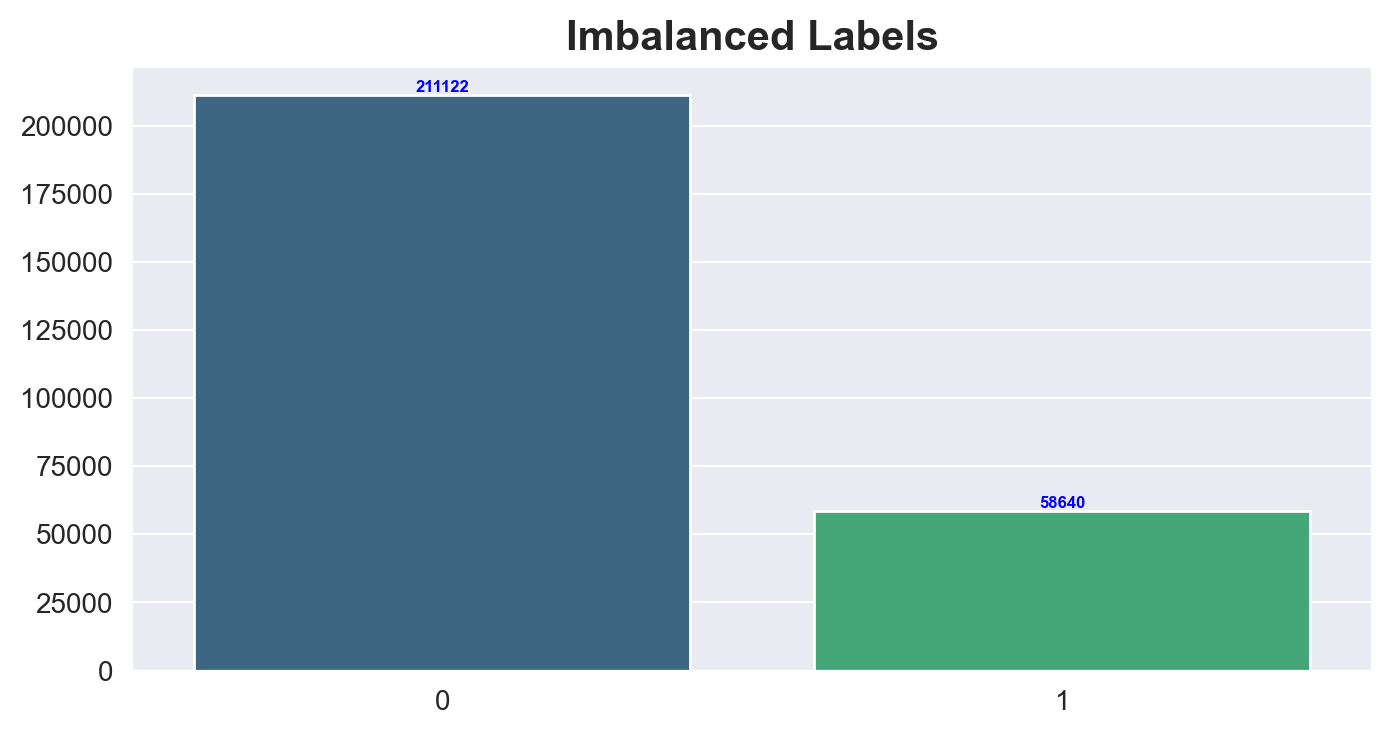

In [123]:
ycount = pd.Series(ds.np_value_counts(y))
display(ycount)
sns.set_style('darkgrid')
viz.plot_column(x=ycount.index, y=ycount, plot_title='Imbalanced Labels')

In [124]:
selector = s_fs.SelectKBest(k='all')
selector.fit(X, y)
top15 = pd.Series(selector.scores_, index=selector.feature_names_in_).sort_values(ascending=False).iloc[:15].index
top15

Index(['urban_or_rural_area', 'speed_limit', 'vehicle_manoeuvre',
       'vehicle_leaving_carriageway', 'sex_of_casualty', 'sex_of_driver',
       'location_northing_osgr', 'casualty_class', 'pedestrian_location',
       'police_force', 'driver_home_area_type', 'local_authority_district',
       '2nd_road_class', 'local_authority_highway', 'casualty_home_area_type'],
      dtype='object')

In [155]:
(x_train, x_val, x_test, y_train, y_val, y_test) = proj.dataset_split(X.values, y_enc.toarray(),
                                                                    perc_test=0.30, perc_val=0.5)

Training: 188834 samples
Validation: 40464 samples
Test: 40464 samples


In [156]:
display(x_train.shape, x_test.shape, x_val.shape, y_train.shape, y_test.shape)

(188834, 30)

(40464, 30)

(40464, 30)

(188834, 2)

(40464, 2)

In [157]:
y_train

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [158]:
scaler = s_prep.MinMaxScaler()

In [160]:
sc_xtrain = pd.DataFrame(scaler.fit_transform(x_train),)
#                          columns=top15)
sc_xtest = pd.DataFrame(scaler.transform(x_test),)
#                         columns=top15)
sc_xval = pd.DataFrame(scaler.transform(x_val),)
#                         columns=top15)

In [161]:
sc_xtest.shape

(40464, 30)

In [162]:
# reduce dimensions using pca to principal components
# with 95% of explained variance
pca = s_decomp.PCA(0.9)
pca.fit(sc_xtrain)
train_pca = pca.transform(sc_xtrain)
test_pca = pca.transform(sc_xtest)
val_pca = pca.transform(sc_xval)

In [164]:
# display(pca.feature_names_in_)

In [165]:
np.cumsum(pca.explained_variance_ratio_)

array([0.25349006, 0.43368926, 0.54427321, 0.64631309, 0.73797242,
       0.80606351, 0.86578035, 0.90490404])

In [166]:
train_pca[0].shape, val_pca.shape, test_pca.shape

((8,), (40464, 8), (40464, 8))

In [169]:
nn = proj.build_nn(train_pca.shape[1], output_units=2, output_actvn='softmax',
              loss='binary_crossentropy', metric='accuracy', lr=3.5e-4)

Input features: 8
Learining Rate: 0.00035


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                720       
                                                                 
 dense_1 (Dense)             (None, 40)                3240      
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                656       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 2)                 34        
                                                                 
Total params

In [170]:
proj.show_layer_shapes(nn)

Layer 0: 
Input_shape: (None, 8)
Output shape: (None, 80)


Layer 1: 
Input_shape: (None, 80)
Output shape: (None, 40)


Layer 2: 
Input_shape: (None, 40)
Output shape: (None, 40)


Layer 3: 
Input_shape: (None, 40)
Output shape: (None, 16)


Layer 4: 
Input_shape: (None, 16)
Output shape: (None, 16)


Layer 5: 
Input_shape: (None, 16)
Output shape: (None, 2)




In [171]:
class_weights = proj.compute_balanced_weights(y, False)
class_weights

{0: 0.6388770473943975, 1: 2.3001534788540248}

In [172]:
nn.fit(train_pca, y_train, epochs=150, validation_data=[val_pca, y_val],
      callbacks=callbacks.EarlyStopping(patience=10, monitor='val_loss'),
       class_weight=class_weights, batch_size=128)

Epoch 1/150
1476/1476 [==============================] - 6s 3ms/step - loss: 0.6818 - val_loss: 0.6658- loss: - ETA
Epoch 2/150
1476/1476 [==============================] - 5s 3ms/step - loss: 0.6748 - val_loss: 0.6664
Epoch 3/150
1476/1476 [==============================] - 5s 3ms/step - loss: 0.6733 - val_loss: 0.6566
Epoch 4/150
1476/1476 [==============================] - 5s 3ms/step - loss: 0.6722 - val_loss: 0.6655
Epoch 5/150
1476/1476 [==============================] - 5s 3ms/step - loss: 0.6709 - val_loss: 0.6599
Epoch 6/150
1476/1476 [==============================] - 6s 4ms/step - loss: 0.6710 - val_loss: 0.6509
Epoch 7/150
1476/1476 [==============================] - 7s 5ms/step - loss: 0.6701 - val_loss: 0.6706
Epoch 8/150
1476/1476 [==============================] - 4s 3ms/step - loss: 0.6692 - val_loss: 0.6648
Epoch 9/150
1476/1476 [==============================] - 6s 4ms/step - loss: 0.6689 - val_loss: 0.6661
Epoch 10/150
1476/1476 [==============================] - 5s

In [174]:
preds = nn.predict(test_pca)
preds.shape

(40464, 2)

In [175]:
y_pred = np.argmax(preds, axis=1)
y_test = np.argmax(y_test, axis=1)

              precision    recall  f1-score   support

           0       0.85      0.56      0.68     31665
           1       0.29      0.63      0.39      8799

    accuracy                           0.58     40464
   macro avg       0.57      0.60      0.54     40464
weighted avg       0.72      0.58      0.62     40464



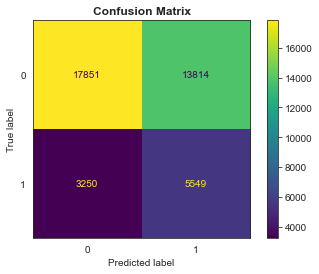

In [176]:
ds.report_with_conf_matrix(y_test, y_pred)

In [294]:
x_data = np.array(test_pca[:3])
# x_data

In [295]:
train_pca.shape, test_pca.shape

((188834, 31), (40464, 31))

In [296]:
pred3 = nn.predict(x_data)

In [297]:
display(pred3, y_test[:3])

array([[5.7245815e-01, 4.2754191e-01],
       [9.0349841e-01, 9.6501589e-02],
       [9.9999619e-01, 3.7881452e-06]], dtype=float32)

array([0, 1, 0], dtype=int64)

In [298]:
fname = 'accident_severity_classifier.h5'
models.save_model(nn, fname)

In [299]:
model = models.load_model(fname, compile=False)

In [300]:
model.predict(x_data)

array([[5.7245815e-01, 4.2754191e-01],
       [9.0349841e-01, 9.6501589e-02],
       [9.9999619e-01, 3.7881452e-06]], dtype=float32)

In [281]:
predictions = proj.predict_accident_severity(accidents)

C:\Users\welcome\venv\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)



Selected accident variables: ('location_easting_osgr', 'location_northing_osgr', 'police_force', 'day_of_week', 'local_authority_district', 'local_authority_highway', '1st_road_class', '1st_road_number', 'road_type', 'speed_limit', 'junction_detail', 'junction_control', '2nd_road_class', '2nd_road_number', 'pedestrian_crossing_human_control', 'pedestrian_crossing_physical_facilities', 'light_conditions', 'weather_conditions', 'road_surface_conditions', 'special_conditions_at_site', 'carriageway_hazards', 'urban_or_rural_area', 'lsoa_of_accident_location', 'vehicle_manoeuvre', 'vehicle_location_restricted_lane', 'junction_location', 'vehicle_leaving_carriageway', 'was_vehicle_left_hand_drive', 'journey_purpose_of_driver', 'sex_of_driver', 'age_of_driver', 'age_band_of_driver', 'engine_capacity_cc', 'propulsion_code', 'age_of_vehicle', 'driver_imd_decile', 'driver_home_area_type', 'vehicle_imd_decile', 'casualty_class', 'sex_of_casualty', 'age_of_casualty', 'age_band_of_casualty', 'pede

In [282]:
predictions

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [86]:
s_mtr.r2_score(y_val, pred)

0.15350876863030471

In [63]:
os.listdir()

['.ipynb_checkpoints',
 'Accident rates and the impact of daylight saving time transitions.docx',
 'adjustment figure guidance.docx',
 'Assignment_BigDataProject-2.docx',
 'Brief-guide-to road-accidents-and-safety-data-1.doc',
 'cas_adjustment_lookup_2019.csv',
 'coversheet2022.docx',
 'EXPLORATORY DATA ANALYSIS FRAMEWOR1.pdf',
 'EXPLORATORY DATA ANALYSIS FRAMEWORK.pdf',
 'My_important_notes.txt',
 'project_methods.py',
 'Road Safety Data - Accidents 2019.csv',
 'Road Safety Data - Casualties 2019.csv',
 'Road Safety Data- Vehicles 2019.csv',
 'RoadAccidentsOutput',
 'Road_accident_project_copy.ipynb',
 'Road_Accident_Report.docx',
 'Road_Accident_Report2.docx',
 'Untitled.ipynb',
 'variable lookup.xls',
 '__pycache__',
 '~$ad_Accident_Report.docx',
 '~$ad_Accident_Report2.docx',
 '~$signment_BigDataProject-2.docx',
 '~WRL0183.tmp',
 '~WRL2660.tmp',
 '~WRL3187.tmp']

In [40]:
cas_adj = pd.read_csv('cas_adjustment_lookup_2019.csv')
cas_adj

,accident_index,Vehicle_Reference,Casualty_Reference,Adjusted_Serious,Adjusted_Slight,Injury_Based
0,200401BS00001,1,1,0.239,0.761,0
1,200401BS00002,1,1,1.000,0.000,0
2,200401BS00003,1,1,0.057,0.943,0
3,200401BS00003,1,2,0.049,0.951,0
4,200401BS00004,1,1,0.187,0.813,0
...,...,...,...,...,...,...
3314732,2019984106919,1,1,0.183,0.817,0
3314733,2019984107019,1,1,0.075,0.925,0
3314734,2019984107219,2,1,0.049,0.951,0
3314735,2019984107419,1,1,0.183,0.817,0


In [42]:
adj_lookup = cas_adj.loc[cas_adj['accident_index'].apply(lambda x: x.startswith('2019')]
adj_lookup

,accident_index,Vehicle_Reference,Casualty_Reference,Adjusted_Serious,Adjusted_Slight,Injury_Based
15346,200401PY20191,1,1,0.030,0.970,0
15347,200401PY20193,1,1,0.066,0.934,0
15348,200401PY20194,1,1,0.107,0.893,0
15349,200401PY20196,1,1,1.000,0.000,0
15350,200401PY20197,2,1,1.000,0.000,0
...,...,...,...,...,...,...
3314732,2019984106919,1,1,0.183,0.817,0
3314733,2019984107019,1,1,0.075,0.925,0
3314734,2019984107219,2,1,0.049,0.951,0
3314735,2019984107419,1,1,0.183,0.817,0
